This notebook shows:
* How to launch the [**StarGANv1**](https://arxiv.org/abs/1711.09020) model for inference
* Example of results for both
    * attrubutes **detection**
    * new face **generation** with desired attributes

Here I use [**PyTorch** implementation](https://github.com/yunjey/stargan) of the StarGANv1 model.

[StarGANv1](https://arxiv.org/abs/1711.09020) was chosen because:
* It provides an ability to generate images **contitionally**. One can control the "amount" of each desired feature via input vector.
* It can **train (relatively) fast** on (relatively) small resources.

The model is pretty old though and has its own drawbacks:
* It works well only with small resolution images (~128).
* For bigger images the artifacts are inavoidable. They sometimes happen even for 128x128 images.

The obvious improvement is to use newer model, e.g., [StarGANv2](https://arxiv.org/abs/1912.01865) which was released in April 2020. It generates much better images at much higher resolution. But it requires both huge resoruces and lots of time to train.

# Imports

Imort necessary libraries

In [1]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.extend(["../code/", "../stargan/"])

import torch
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

from config import get_config

from solver import Solver

# Load model

Let's first load the config for the model. It is mostly default except for the:

* model checkpoint path
* style classes, their order and number

Note that in the original StarGANv1 model 5 classes are used: `[Black_Hair Blond_Hair Brown_Hair Male Young]`.

I use all the classes connected to hairstyle (see `DataExploration` notebook) which are: `[Black_Hair Blond_Hair Brown_Hair Gray_Hair Bald Bangs Receding_Hairline Straight_Hair Wavy_Hair]`.

In [2]:
config = get_config("""
--model_save_dir ../models/celeba_128_custom/
--test_iters 200000
--c_dim 9
--selected_attrs Black_Hair Blond_Hair Brown_Hair Gray_Hair Bald Bangs Receding_Hairline Straight_Hair Wavy_Hair
""")

Load the model architecture with the provided config.

In [3]:
model = Solver(None, None, config)

Generator(
  (main): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vovacher/anaconda3/lib/python3.7/site-package

Restore model weights.

In [4]:
model.restore_model(model.test_iters)

Loading the trained models from step 200000...


# Prediction example

Let's read a test image.

Note that the **face position and size** should be comparable to what the model has seen in the training data (CelebA). Here I do not use any face detector and crop the faces manually. But in production environment one needs to setup the face detector correspondingly.

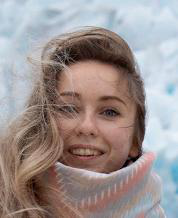

In [5]:
image = Image.open("../data/test.jpg")
image

The input to the network is **3x128x128 image in a range [-1; 1]** (note that the channels is the first dimension).

Thus one need to do preprocessing in advance.

In [6]:
transform = []
transform.append(T.Resize(128))
transform.append(T.CenterCrop(128))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

Create a batch of 1 image

In [7]:
x_real = torch.stack([transform(image)])
x_real.shape

torch.Size([1, 3, 128, 128])

## Attributes prediction

Let's first predict the attbibutes of the image. To do so I use the **Discriminator** part of the network. In StarGAN architecture it predicts not only the fake/real label but also the classes/attributes/styles of the image.

Here I call this vector **eigen style vector**. Note that due to the possible co-existence of multiple labels and the corresponding training procedure (Sigmoid + BCELoss instead of Softmax + CrossEntropyLoss) I use sigmoid activation function here and treat predicted labels separately (instead of 1-of-all). 

In [8]:
with torch.no_grad():
    eigen_style_vector = torch.sigmoid(model.D(x_real)[1])

Below is the probability of each label. The photo indeed depicts a person with brown/blond wavy hair.

In [9]:
for proba, tag in zip(eigen_style_vector.numpy()[0], model.selected_attrs):
    print(f"{tag:20s}: {proba:.3f}")

Black_Hair          : 0.000
Blond_Hair          : 0.151
Brown_Hair          : 0.059
Gray_Hair           : 0.001
Bald                : 0.000
Bangs               : 0.000
Receding_Hairline   : 0.063
Straight_Hair       : 0.042
Wavy_Hair           : 0.213


Now let's look at how well the **Generator** model can recreate the face without altering it using the just computed eigen style vector.

In [10]:
with torch.no_grad():
    res_eigen = model.G(x_real, eigen_style_vector)
res_eigen.shape

torch.Size([1, 3, 128, 128])

Plot the original face and the reconstructed one:

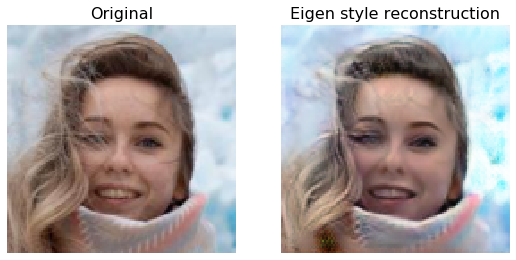

In [11]:
plt.figure(figsize=(9, 8))

plt.subplot(121)
_img = model.denorm(x_real).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Original", fontsize=16)

plt.subplot(122)
_img = model.denorm(res_eigen).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Eigen style reconstruction", fontsize=16);

Looks good enough.

## Face modification using new attributes

Now let's try to modify the face starting from the eigen style vector.

Let's say I want to **make the hair black**. To do so I am to set all other hair color components to 0 and black component to 1.

In [12]:
eigen_style_vector_modified_1 = eigen_style_vector.clone()
eigen_style_vector_modified_1[:, 0] = 1
eigen_style_vector_modified_1[:, 1] = 0
eigen_style_vector_modified_1[:, 2] = 0
eigen_style_vector_modified_1[:, 3] = 0

Now the style vector looks the following:

In [13]:
for proba, tag in zip(eigen_style_vector_modified_1.numpy()[0], model.selected_attrs):
    print(f"{tag:20s}: {proba:.3f}")

Black_Hair          : 1.000
Blond_Hair          : 0.000
Brown_Hair          : 0.000
Gray_Hair           : 0.000
Bald                : 0.000
Bangs               : 0.000
Receding_Hairline   : 0.063
Straight_Hair       : 0.042
Wavy_Hair           : 0.213


Let's try to generate face with this modified style vector:

In [14]:
with torch.no_grad():
    res_modified_1 = model.G(x_real, eigen_style_vector_modified_1)
res_modified_1.shape

torch.Size([1, 3, 128, 128])

Plot the faces:

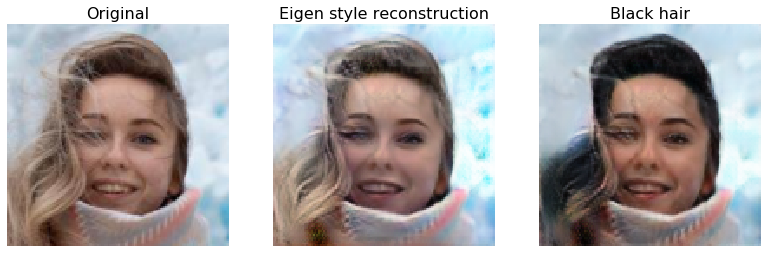

In [15]:
plt.figure(figsize=(13.5, 8))

plt.subplot(131)
_img = model.denorm(x_real).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Original", fontsize=16)

plt.subplot(132)
_img = model.denorm(res_eigen).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Eigen style reconstruction", fontsize=16);

plt.subplot(133)
_img = model.denorm(res_modified_1).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Black hair", fontsize=16);

Looks good.

Now let's try to **change two attributes simultaneously**:
* Make the hair blond
* Add bangs

In [16]:
eigen_style_vector_modified_2 = eigen_style_vector.clone()
eigen_style_vector_modified_2[:, 0] = 0
eigen_style_vector_modified_2[:, 1] = 1
eigen_style_vector_modified_2[:, 2] = 0
eigen_style_vector_modified_2[:, 3] = 0
eigen_style_vector_modified_2[:, 5] = 1

Now the style vector looks the following:

In [17]:
for proba, tag in zip(eigen_style_vector_modified_2.numpy()[0], model.selected_attrs):
    print(f"{tag:20s}: {proba:.3f}")

Black_Hair          : 0.000
Blond_Hair          : 1.000
Brown_Hair          : 0.000
Gray_Hair           : 0.000
Bald                : 0.000
Bangs               : 1.000
Receding_Hairline   : 0.063
Straight_Hair       : 0.042
Wavy_Hair           : 0.213


Let's try to generate face with this modified style vector:

In [18]:
with torch.no_grad():
    res_modified_2 = model.G(x_real, eigen_style_vector_modified_2)
res_modified_2.shape

torch.Size([1, 3, 128, 128])

Plot the faces:

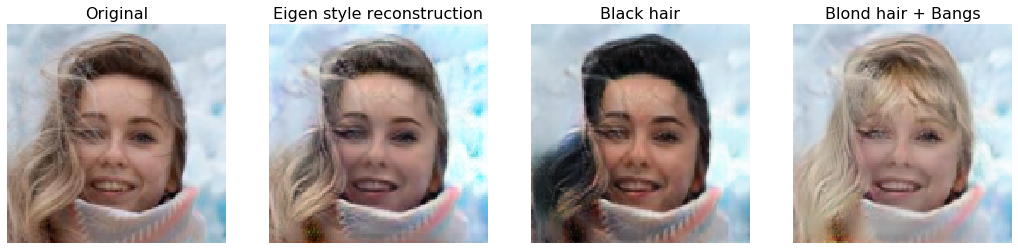

In [19]:
plt.figure(figsize=(18, 8))

plt.subplot(141)
_img = model.denorm(x_real).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Original", fontsize=16)

plt.subplot(142)
_img = model.denorm(res_eigen).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Eigen style reconstruction", fontsize=16);

plt.subplot(143)
_img = model.denorm(res_modified_1).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Black hair", fontsize=16);

plt.subplot(144)
_img = model.denorm(res_modified_2).numpy()[0].transpose((1, 2, 0))
plt.imshow(_img)
plt.axis("off")
plt.title("Blond hair + Bangs", fontsize=16);

Looks good!